In [1]:
import numpy
import py_entropy
from matplotlib import pyplot
import os

from tqdm.notebook import tqdm

pyplot.rcParams.update({
  "text.usetex": True,
  "font.family": "Helvetica"
})

In [2]:
output_dir = "dephased_states"

os.makedirs(output_dir, exist_ok=True)

# Uniformly Delocalized and Mixed

In [3]:
def dephase_site(site, probs_and_states):
    all_ps_ss = []
    for p,s in probs_and_states:
        (pa,sa), (pb,sb) = s.trace_out_site(site)
        if pa > 0.0:
            all_ps_ss.append((p*pa, sa))
        if pb > 0.0:
            all_ps_ss.append((p*pb, sb))
    return all_ps_ss

def dephase_sites(start,end,probs_and_states):
    for i in range(start, end):
        probs_and_states = dephase_site(i, probs_and_states)
    return probs_and_states

In [4]:
n = 12
ne = 1000
k = 10000

input_states = []
for i in range(n):
    for j in range(i+1,n):
        input_states.append([i,j])
input_states = numpy.array(input_states).astype(numpy.uint64)
D = len(input_states)
amplitudes = numpy.ones((len(input_states)), dtype=numpy.complex128) / numpy.sqrt(D)
ps = py_entropy.MultidefectPureState(input_states, amplitudes)

all_purities = []

for i in tqdm(range(0,n+1)):
    probs_and_states = dephase_sites(0,i,[(1.0, ps)])
        
    s = py_entropy.MultiDefectState.new_mixed_from_states(probs_and_states,
                                    n,
                                    num_experiments=ne, 
                                    skip_float_checks=True)
    initial_purity = s.get_mean_purity()
    purities = s.apply_alternative_layers_and_save_mean_purity(k)
    purities = numpy.hstack([numpy.expand_dims(initial_purity, axis=0), purities])
    all_purities.append(purities)
all_purities = numpy.array(all_purities)

filename = f"dephased_uniform_l={n}"

numpy.savez(filename, data=all_purities, D=D)

  0%|          | 0/13 [00:00<?, ?it/s]

In [20]:
true_purities = []
for i in range(0,n+1):
    probs_and_states = dephase_sites(0,i,[(1.0, ps)])
    true_purities.append(sum(p**2 for p, _ in probs_and_states))
true_purities

[1.0,
 0.7222222222222223,
 0.5110192837465565,
 0.3539944903581268,
 0.24012855831037652,
 0.15977961432506887,
 0.10468319559228648,
 0.06795224977043157,
 0.044077134986225903,
 0.028925619834710748,
 0.01974288337924701,
 0.015151515151515138,
 0.015151515151515138]

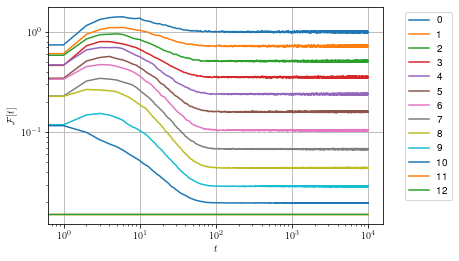

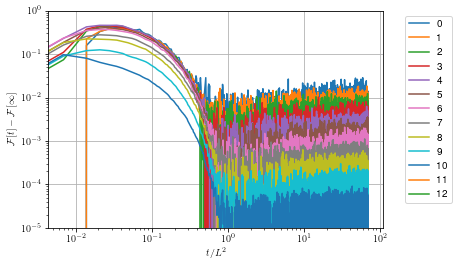

In [26]:
for i,purs in enumerate(all_purities):
    pyplot.plot(purs, label=f'{i}')
pyplot.xscale('log')
pyplot.yscale('log')
pyplot.ylabel('$\mathcal{F}[t]$')
pyplot.xlabel('$t$')
pyplot.legend(bbox_to_anchor=(1.05,1.0))
pyplot.grid()
pyplot.show()

for i,purs in enumerate(all_purities):
    pyplot.plot(numpy.arange(len(purs))/n**2, purs - true_purities[i], label=f'{i}')
pyplot.xscale('log')
pyplot.yscale('log')
pyplot.ylim([1e-5,1e0])
pyplot.ylabel('$\mathcal{F}[t] - \mathcal{F}[\infty]$')
pyplot.xlabel('$t/L^2$')
pyplot.legend(bbox_to_anchor=(1.05,1.0))
pyplot.grid()
pyplot.show()

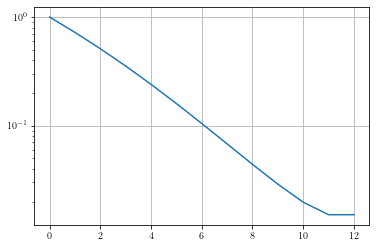

In [22]:
pyplot.plot(true_purities)
pyplot.yscale('log')
pyplot.grid()